In [2]:
import math
import pandas as pd
import tqdm
import numpy as np

import torch
import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [3]:
def imine_loss(tj, tm, p=1/16, regularizer_weight=0, center_value=0):
    t = tj
    et = np.log(p*(np.exp(tj)) + (1.0-p)*(np.exp(tm)))
    return t-et-regularizer_weight * (et-center_value)**2


def experiment(use_imine=True, regularizer_weight=0.1):
    data_loader = data.DataLoader(
        datasets.IntegerPairDataset(
            number_of_cases=16,
            x_encoding='one_hot',
            y_encoding='one_hot',
            transform=datasets.TransformToTensor()
        ),
        batch_size=100,
    )
    if use_imine:
        loss = losses.imine_loss(target_value=0, regularizer_weight=regularizer_weight)
    else:
        loss = losses.mine_loss()
    network = models.ConcatNet(16, 64)
    optimizer = optim.SGD(network.parameters(), lr=0.1)

    agent = controller.MINEController(
        data_loader=data_loader, loss=loss, network=network, optimizer=optimizer
    )
    
    agent.to(0)
    agent.train()
    for i in tqdm.tqdm(range(3000)):
        agent.step()

    return agent

In [5]:
imine_histories = [experiment(False).history]
weights = [0.0, 0.01, 0.1, 1.0]
for w in weights:
    imine_histories.append(experiment(True, w).history)

100%|██████████| 3000/3000 [01:14<00:00, 40.29it/s]


In [261]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib

matplotlib.rc('font', size=16)

batch_size = 100

def get_linecollection(history):
    iterations = len(history)
    t, et = [], []
    for i in range(0, iterations, batch_size):
        df_window = history[i:i+batch_size]
        # t.append(np.average(df_window[df_window.is_joint_case == 1.0].marginal_value))
        t.append(np.average(df_window.joint_value))
        et.append(np.average(df_window[df_window.is_joint_case == 0.0].marginal_value))

    points = np.array([t, et]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='cividis', norm=plt.Normalize(0, len(t)))
    lc.set_array(np.array(range(len(t))))

    return lc

def get_contour(use_imine, regularizer_weight=None):
    X = np.arange(-5, 5, 1/20)
    Y = np.arange(-10, 5, 1/20)
    X, Y = np.meshgrid(X, Y)
    if use_imine:
        Z = imine_loss(X, Y, regularizer_weight=regularizer_weight)
    else:
        Z = imine_loss(X, Y, regularizer_weight=0)
    return X, Y, Z


<IPython.core.display.Javascript object>


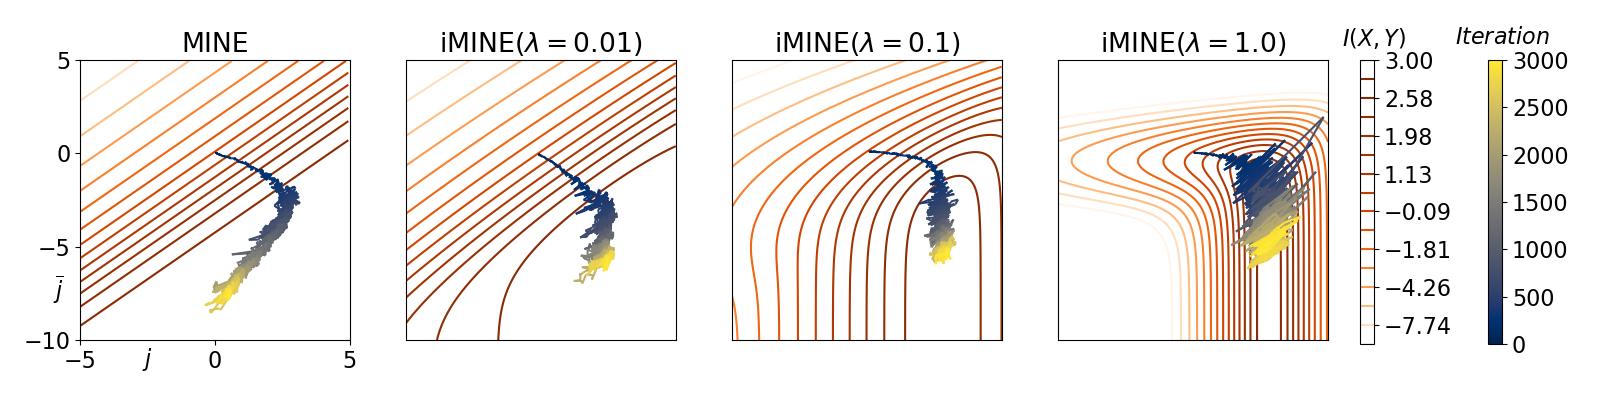

In [262]:
%matplotlib notebook

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

#plt.subplot(1, 4, 1)
for i in range(4):
    lc = get_linecollection(imine_histories[i])
    if i == 0:
        X, Y, Z = get_contour(False)
    else:
        X, Y, Z = get_contour(True, weights[i])

    cntr = axes[i].contour(
        X, Y, Z,
        levels=sorted(4-np.geomspace(1, 14, 16, endpoint=True)),
        cmap='Oranges',
    )
    line = axes[i].add_collection(lc)
    

    # plt.xlim(-5, 5)
    # plt.ylim(-10, 5)
    if i == 0:
        axes[i].set_xticks([-5, 0, 5])
        axes[i].set_yticks([-10, -5, 0, 5])
        axes[i].set_title('MINE')
        axes[i].set_xlabel('$j$')
        axes[i].set_ylabel('$\overline{j}$')
    else:
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f'iMINE($\lambda={weights[i]}$)')
    
    if i == 3:
        linecolo = fig.colorbar(line, ax=axes.ravel().tolist())
        cntrcolo = fig.colorbar(cntr, ax=axes.ravel().tolist())

plt.show()

In [263]:
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.83, bottom=0.15, top=0.85)

axes[0].xaxis.set_label_coords(0.25, -0.02)
axes[0].yaxis.set_label_coords(-0.08, 0.12)
axes[0].yaxis.label.set_rotation(0)

linecolo.set_label('$Iteration$')
linecolo.ax.yaxis.label.set_rotation(0)
linecolo.ax.set_position([0.93, 0.14, 0.7, 0.71])
linecolo.ax.yaxis.set_label_coords(1, 1.12)

cntrcolo.set_label('$I(X, Y)$')
cntrcolo.ax.yaxis.label.set_rotation(0)
cntrcolo.ax.set_position([0.85, 0.14, 0.7, 0.71])
cntrcolo.ax.yaxis.set_label_coords(1, 1.12)

plt.show()

/home1/irteam/users/siyeong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


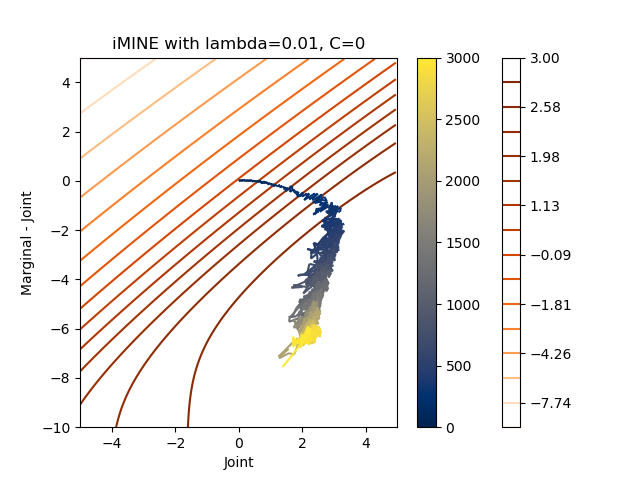

<IPython.core.display.Javascript object>


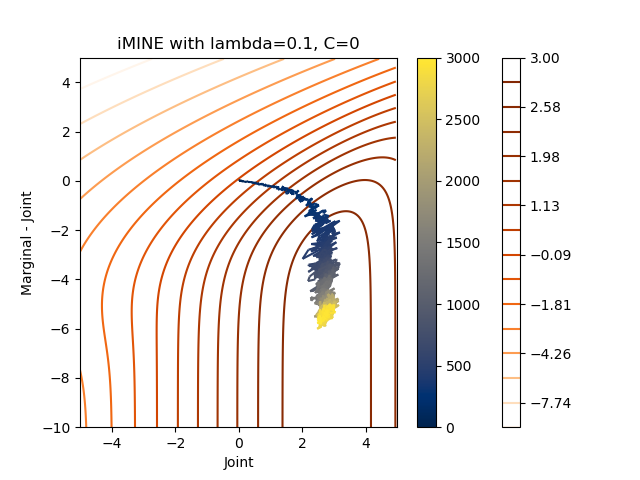

<IPython.core.display.Javascript object>


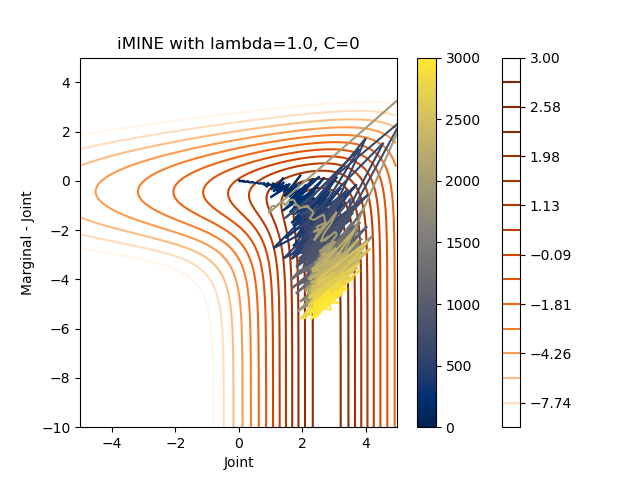

In [10]:
%matplotlib notebook

for i, imine_history in enumerate(imine_histories):
    fig, ax = plt.subplots()
    ax.set_xlabel('Joint')
    ax.set_ylabel('Marginal - Joint')

    lc = get_linecollection(imine_history)
    X, Y, Z = get_contour(True, weights[i])

    plt.colorbar(ax.contour(
        X, Y, Z,
        levels=sorted(4-np.geomspace(1, 14, 16, endpoint=True)),
        cmap='Oranges',
    ), ax=ax)
    fig.colorbar(
        ax.add_collection(lc),
        ax=ax,
    )
    
    plt.xlim(-5, 5)
    plt.ylim(-10, 5)

    plt.title(f'iMINE with lambda={weights[i]}, C=0')
    plt.show()